In [1]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import itertools

In [2]:
from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.algorithms import VQE
from qiskit.utils import QuantumInstance
from qiskit.circuit import QuantumCircuit, ClassicalRegister

In [3]:
# define the adjacency matrix
adj_matrix = np.array([[0, 1, 2, 3, 4],
                       [1, 0, 5, 6, 7],
                       [2, 5, 0, 8, 9],
                       [3, 6, 8, 0, 10],
                       [4, 7, 9, 10, 0]])

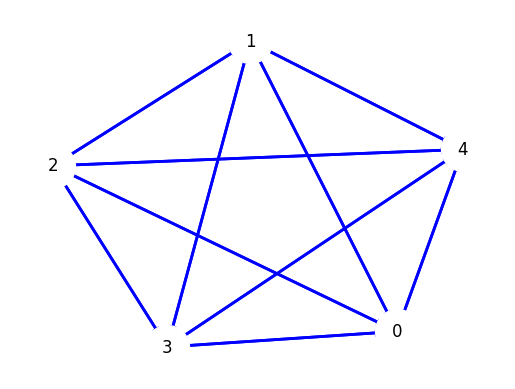

In [4]:
# Draw the graph
G = nx.DiGraph()
G.add_nodes_from(range(5))
pos = nx.spring_layout(G)
labels = {i:i for i in range(5)}
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='w')
nx.draw_networkx_labels(G, pos, labels)
nx.draw_networkx_edges(G, pos)
for i in range(5):
    for j in range(5):
        if adj_matrix[i][j] > 0:
            G.add_edge(i, j, weight=adj_matrix[i][j])
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='b', width=2)
plt.axis('off')
plt.show()

In [5]:
# Brute force solution
shortest_distance = float('inf')
shortest_path = None
for path in itertools.permutations(range(5)):
    path_distance = sum(adj_matrix[path[i]][path[i+1]] for i in range(4))
    if path_distance < shortest_distance:
        shortest_distance = path_distance
        shortest_path = path
print("Brute force solution:")
print("shortest path:", shortest_path)
print("shortest distance:", shortest_distance)

Brute force solution:
shortest path: (3, 0, 2, 1, 4)
shortest distance: 17


In [ ]:
tsp = Tsp(adj_matrix)
qp = tsp.to_quadratic_program()
qubo_converter = QuadraticProgramToQubo()
qubo = qubo_converter.convert(qp)
qubit_op, offset = qubo.to_ising()
algorithm_globals.random_seed = 1234
spsa = SPSA(maxiter=25)
backend = Aer.get_backend('qasm_simulator')
backend_options = {"shots": 100}
quantum_instance = QuantumInstance(backend, shots=backend_options["shots"])
ansatz = TwoLocal(qubit_op.num_qubits, ['ry', 'rz'], 'cz')
vqe = VQE(ansatz=ansatz, optimizer=spsa, quantum_instance=quantum_instance)
vqe_result = vqe.compute_minimum_eigenvalue(qubit_op)
vqe_solution = tsp.interpret(vqe_result.eigenstate)
vqe_distance = tsp.objective_value(vqe_solution)

In [8]:
# Print the VQE solution and distance
print("VQE solution", vqe_solution)
print("VQE shortest distance", vqe_distance)

VQE solution: [3, 0, 2, 1, 4]
VQE shortest distance: 17.0
